# Hyper-graphical extensions of randomly grown neural networks #

_Ramón Nartallo-Kaluarachchi; MAJ5 Structures of Complex Systems; 2021-2022_

### 1. Introduction ###

Within both machine learning and computational neuroscience, there is a sub field focused on building biologically motivated artificial neural networks that mimic the function of the human brain. However, even these networks typically neglect network topology and structure as a important biological feature, often opting for random or arbitrary connectivity. An interesting approach to the problem of 
producing biologically motivated and plausible connectivity in networks is emulating the dynamics of biological neural growth.

In the model discussed here, neurons are modelled as rooted binary trees governed by a branching process. The branching rate in this state-of-the-art model is assumed to be 'a monotonically decreasing function of time'. In this project, the model used was presented by Ajazi et al. [1]. It is a simplification of the NETMORPH model that assumes a constant branching rate for all times [2]. The model is also restricted to 2D.

This Jupyter notebook and the associated Python files allow for the simulation of the models discussed both here and in the report. The notebook, report and Python scripts are available at https://github.com/rnartallo/randomlygrownnetworks. The code is written in Python3.

In order to run the code, one must clone the entire repository with all accompanying Python files and install the following dependencies:

In [3]:
import random as r
import numpy as np
import math as m
import matplotlib.pyplot as plt
import networkx as nx
import mynetworkx as my_nx

### 2. A model of a single neuron ###

_You will need ***'singleneuronmodel.py'*** for this chapter._

The model presented here was first presented Ajazi et al. (2015) [1].
It is a direct simplification of the model presented in Acimov´ıc et
al. (2011) [3].

A __neuron__ is assumed to be, at any time, a rooted, random tree.
We call the root the __soma__ of the neuron. The branches of the tree
represent the growing __axons__ of the neuron.
We denote our time parameter by $t \geq 0$. At time $t = 0$, the neuron
is represented by a single point $s \in \mathbb{R}^2$, the soma. At any time $t$, the
neuron is represented by the random tree $N_s(t)\subset \mathbb{R}^2$. The neural
growth is governed by the two processes of ***elongation*** and ***branching***
of axons.

At $t=0$, a segment begins to grown from $s$ in a random direction between two parameters: the angle upper-bound, $\theta_U$; and the angle lower-bound, $\theta_L$. The segment grows with constant speed, set to 1. This is not a restriction as time can be rescaled. At a random time $\tau_0$, governed by an exponential distribution with mean $1/\lambda$, the segments splits into two new segments with random directions between the bounds. These develop independently in the same manner. Each of these segments will split at times $\tau_0+\tau_1$ and $\tau_0+\tau_2$ respectively. The $\tau_i$ are independently, identically distributed from the same exponential distribution with mean $1/\lambda$. This process repeats whilst $t<T$; where $T$ is a parameter representing the total time given for growth.

The parameters for this model are:
 - $s$ - the start point of the neuron and the position of the soma.
 - $\theta_U$ - the angle upper-bound for the direction of an axon.
 - $\theta_L$ - the angle lower-bound for the direction of an axon.
 - $\lambda$ - the rate/inverse scale of the exponential distribution governing branching times.
 - $T$ - the stopping time for the model.



The single neuron model can be simulated using the function below. The code is in the file 'singleneuronmodel.py'

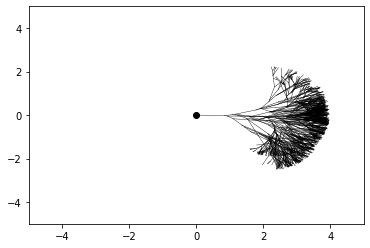

In [6]:
import singleneuronmodel as snm
plt.xlim(right=5,left=-5)
plt.ylim(top=5,bottom=-5)
plt.scatter(0,0,color="black")

#Parameters are (angle_lower_bound,angle_upperbound,T,lambd,initial_position)
edges = snm.growingneuron(-m.pi/6,m.pi/6,4,2,[0,0])

### 3. A network level model

_You will need ***'networkmodel.py'*** and ***'nmgraphtools.py'*** for this chapter._

#### 3.1. Connectivity ###

In order to construct networks from this single neuron model, Ajazi et al. define a notion of connectivity for two neurons grown on the same plane [1].

Firstly, we define a notion of distance between the tree of a neuron starting at $s$, $N_s(t)$, and a point $\omega$.

***Definition 1.*** Let $N_s(t)$ represent the axonal tree of a neuron starting at $s$ after time $t$. Let $\omega \in \mathbb{R}^2$. The ***distance*** between $N_s(t)$ and $\omega$ is denoted by $d(N_s(t),\omega)$ where
\begin{align}
    d(N_s(t),\omega):=\min\{||x-\omega||:x\in N_s(t)\}
\end{align}
where $||\cdot||$ represents the standard Euclidean distance in $\mathbb{R}^2$

With this notion of distance, we now introduce a new parameter, $r$, called the ***radius***. We now define our notion of directed connectivity.

***Definition 2.*** Let $N_s(t),N_\omega(t)$ represent the axonal trees of neurons $S,\Omega$ starting at $s,\omega$ after time $t$. Let $r$ be the radius, a given parameter in the model. We say that neuron $S$ is ***connected*** to neuron $\Omega$ if $d(N_s(t),\omega)\leq r$.

In order to use the notion of connectivity, we must be able to calculate this distance for a practical example. A method for calculating this distance depends on how the neuron is simulated. A fair assumption is to assume that once a neuron is simulated, we have stored the ***edge-set*** of the axonal tree. This is a set $E\subset \mathbb{R}^2\times\mathbb{R}^2$ and uniquely defines the tree.

Let $S_e$ represent the segment connecting the two endpoints for an edge $e=[(a_1,b_1),(a_2,b_2)]$. Then we have that,
\begin{align}
    d(N_s(t),\omega)&=\min\{d(S_e(t),\omega):e\in E\}
\end{align}
where $N_s(t)$ is the axonal tree of a neuron starting at $s$, $E$ is its edge set and $\omega \in \mathbb{R}^2$.

We follow P. Bourke’s method for finding the distance between a
point and a segment [4].

In [7]:
import networkmodel as nm
#Parameters are (P1,P2,P) where the segment connects P1 and P2 and P is another point - the function returns the distance between the segment and P
nm.dist_point_to_segment([0,0],[0,1],[6,0.5])

6.0

#### 3.2. Networks of neurons  

Following again from Ajazi et al., we assume the soma of the neurons are distributed randomly on some rectangle $[x_1,x_2]\times[y_1,y_2]$ forming a 2D Poisson process with intensity $\mu$ [1].

Our model has now expanded its parameter set to include, in addition to the previous parameters,
 - $[x_1,x_2],[y_1,y_2]$ - the dimensions of the rectangle in the plane where the soma can be placed.
 - $r$ - the radius of connectivity.
 - $\mu$ - the intensity of the Poisson process governing the number of soma. 
 

In order to simulate a network, we first place the soma, by simulating a Poisson process and then grow an axonal from each of these soma using the single neuron model. Finally we determine the connectivity of these neurons and build the adjacency matrix.

This code is in the file ***'networkmodel.py'***. It can take a few seconds to display

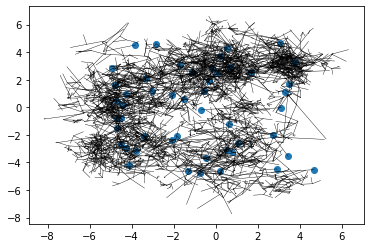

In [9]:
import networkmodel as nm
#Parameters are (mu,x_range,y_range,angle_lowerbound,angle_upperbound,T,lambda,radius)
Network = nm.growRandomNetwork(0.4,[-5,5],[-5,5],-m.pi,m.pi,4,1,1)

We can display this as a network using the ***NetworkX*** Python package.

In [10]:
import nmgraphtools as nmgt
G=nmgt.makeGraph(Network)
nmgt.plotGraph(G)

NameError: name 'makeGraph' is not defined

And then perform basic analysis,

In [ ]:
nmgt.basicAnalysisGraph(G)
nmgt.plotDegreeDistribution(G)